# Importation des modules

In [119]:
# Pour interagir avec le système d'exploitation : lecture et écriture de fichiers, création de répertoires, exécution de commandes système.
import os

# Fournit des fonctions mathématiques et des constantes.
import math

# Manipuler les données
import matplotlib.pyplot as plt
import pandas as pd

# Charger des variables d'environnement 
from dotenv import load_dotenv

# Classe du SDK Azure qui fournit une méthode d'authentification à l'aide d'une clé API.
from azure.core.credentials import AzureKeyCredential

# Classe du SDK Azure qui permet d'accéder au service d'analyse de texte d'Azure,
from azure.ai.textanalytics import TextAnalyticsClient

import requests
import json

# Préparation de l'API

In [53]:
# Charge les variables d'environnement à partir du fichier .env
load_dotenv('.env')

# Point de terminaison et clé API
endpoint = os.environ["AZURE_LANGUAGE_ENDPOINT"]
key = os.environ["AZURE_LANGUAGE_KEY"]

# Authentification de l'objet client
text_analytics_client = TextAnalyticsClient(endpoint, AzureKeyCredential(key))

# Dataset

In [120]:
df = pd.read_csv("../dataset_fr_reseaux_socio.csv")
df

,text,label,sentiment
0,"Royal: le président n'aime pas les pauvres? ""c...",0,negative
1,La 'fashionweek' du fleurissement - Site Offic...,1,neutral
2,#press #seo: Nager vert avec les piscines écol...,2,positive
3,#Biodiversité #Gard : Des Lézards ocellés détr...,0,negative
4,"#Sicav #FCP : une sélection de valeurs ""dévelo...",1,neutral
...,...,...,...
865,Terre de biodiversité &gt; http &gt; Conseil g...,1,neutral
866,Le #Panama c'est une variété de paysages mais...,2,positive
867,. @user @user OVH ils font du Greenwhasing sur...,0,negative
868,A relire sur [http 4 secrets beauté du marc de...,1,neutral


In [121]:
df['label'].unique()

array([0, 1, 2])

<Axes: >

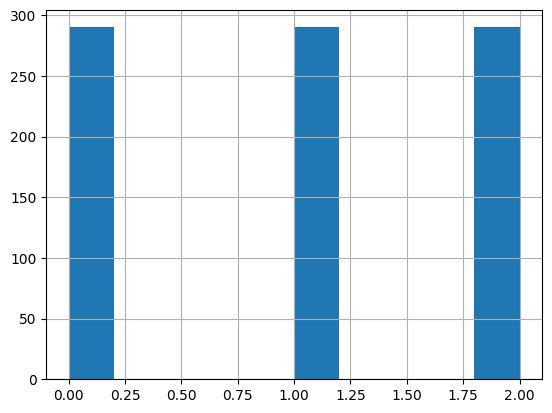

In [122]:
df['label'].hist()

In [123]:
df['sentiment'].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

# Découverte

In [115]:
# Phrases à analyser
documents = [" C'est inacceptable, je ne me sens pas en sécurité avec votre banque.","J'apprécie vraiment votre réactivité et votre service client."]

# Analyse de sentiments
response = text_analytics_client.analyze_sentiment(documents)
successful_responses = [doc for doc in response if not doc.is_error]

In [116]:
successful_responses

[AnalyzeSentimentResult(id=0, sentiment=negative, warnings=[], statistics=None, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0), sentences=[SentenceSentiment(text= C'est inacceptable, je ne me sens pas en sécurité avec votre banque., sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0), length=69, offset=0, mined_opinions=[])], detected_language=None, is_error=False, kind=SentimentAnalysis),
 AnalyzeSentimentResult(id=1, sentiment=positive, warnings=[], statistics=None, confidence_scores=SentimentConfidenceScores(positive=0.99, neutral=0.01, negative=0.0), sentences=[SentenceSentiment(text=J'apprécie vraiment votre réactivité et votre service client., sentiment=positive, confidence_scores=SentimentConfidenceScores(positive=0.99, neutral=0.01, negative=0.0), length=61, offset=0, mined_opinions=[])], detected_language=None, is_error=False, kind=SentimentAnalysis)]

In [117]:
# Affichage
for doc in successful_responses:
    print(doc.sentiment)

negative
positive


# Test sur le dataset

In [85]:
# Séparer les documents en lots de 10 documents maximum
documents = df["text"].tolist()
batch_size = 10
batches = [documents[i:i+batch_size] for i in range(0, len(documents)-batch_size, batch_size)]

# Calculer le nombre d'enregistrements de texte utilisés
num_chars = sum([len(doc) for doc in documents])
num_text_records = math.ceil(num_chars / 1000)

# Calculer le coût approximatif de l'analyse de sentiment
cost = num_chars / 1000000
print("Nombre total d'enregistrements texte : ", num_text_records)
print("Coût approximatif : ", cost, "$")

Nombre total d'enregistrements texte :  83
Coût approximatif :  0.082187 $


In [91]:
# Analyser chaque lot de documents
successful_responses = []
for batch in batches:
    response = text_analytics_client.analyze_sentiment(batch)
    successful_responses += [doc for doc in response if not doc.is_error]

In [92]:
# Afficher les colonnes
print('{:<10}{:<20}{:<10}'.format('Sentiment', 'Prediction de l\'API', 'Correct?'))

# Calcul du nombre de réponses correctes
num_correct = 0

# Récupération des phrases avec prédiction différente du label
liste_recup = []

# Affichage des résultats ligne par ligne
for i in range(len(successful_responses)):
    # Récupération du sentiment correspondant à la phrase analysée
    sentiment = df.loc[i, 'sentiment']
    # Récupération de la prédiction de l'API Text Analytics
    prediction = successful_responses[i].sentiment
    # Vérification si la prédiction est correcte
    if sentiment == prediction:
        correct = 1  
    else: 
        correct = 0
        liste_recup += [(df['text'][i], sentiment, prediction)]

    # Incrémentation du nombre de réponses correctes
    num_correct += correct
    # Affichage de la ligne correspondant au résultat
    print('{:<10}{:<20}{:<10}'.format(sentiment, prediction, correct))

# Calcul et affichage du pourcentage de réponses correctes
accuracy = num_correct / len(successful_responses) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

Sentiment Prediction de l'API Correct?  
negative  negative            1         
neutral   neutral             1         
positive  neutral             0         
negative  negative            1         
neutral   neutral             1         
positive  neutral             0         
negative  neutral             0         
neutral   positive            0         
positive  neutral             0         
negative  neutral             0         
neutral   neutral             1         
positive  positive            1         
negative  negative            1         
neutral   neutral             1         
positive  neutral             0         
negative  negative            1         
neutral   neutral             1         
positive  positive            1         
negative  neutral             0         
neutral   neutral             1         
positive  neutral             0         
negative  negative            1         
neutral   neutral             1         
positive  mixed 

In [93]:
liste_recup

[('#press #seo: Nager vert avec les piscines écologiques http #piscineécologique',
  'positive',
  'neutral'),
 ('Etat des lieux et analyse des mécanismes de soutien public aux énergies renouvelables en France ►► http',
  'positive',
  'neutral'),
 ("Les espèces disparaissent 1.000 fois plus depuis que l'Homme existe | @user http",
  'negative',
  'neutral'),
 ("Master Management de l'Envrironnement et du Développement Durable ou Master Économie et Développement du Territoire.. À choisir 💭💭",
  'neutral',
  'positive'),
 ('Une entreprise allemande propose une solution éco-efficace de ferme urbaine http #NRJ(Canada) #RegionsofFrance',
  'positive',
  'neutral'),
 ('Réchauffement : l’ONU prédit un véritable «enfer climatique» d’ici 2050 http http',
  'negative',
  'neutral'),
 ("Réchauffement climatique: il est grand temps d'agir - http",
  'positive',
  'neutral'),
 ('Polémique autour de l’abattage massif de bouquetins en Haute-Savoie | Eco(lo) http',
  'negative',
  'neutral'),
 ("Echa

In [94]:
liste_recup_2 = []
for element in liste_recup:
    if element[1]=="negative" and element[2]=="positive":
        liste_recup_2 += [element]
    elif element[1]=="positive" and element[2]=="negative":
        liste_recup_2 += [element]

liste_recup_2

[('#Bargy. Polémique sur l’#abattage massif de #bouquetins - http #Extermination pour plaire aux éleveurs, chasseurs et élus',
  'negative',
  'positive'),
 ("Je n'ai vu AUCUN sujet sur l'environnement, le développement durable ; à se demander pourquoi c'est au programme :/",
  'negative',
  'positive'),
 ('Barrage de Sivens : Non à la répression, oui à l’intérêt général | Europe Écologie Les Verts http via @user',
  'positive',
  'negative'),
 ("La Californie vient d'interdire la distribution de sacs plastiques ! #ecologie  http @user",
  'positive',
  'negative'),
 ('#Climat "Plus ns attendons, plus l\'addition sera élevée" il y a urgence! L\'appel de #BanKiMoon @user http #Paris2015',
  'negative',
  'positive'),
 ('Un préjudice écologique important - http #GoogleAlerts',
  'positive',
  'negative'),
 ("Le 'chat le plus triste du monde' reçoit des milliers de demandes d'adoption http",
  'positive',
  'negative'),
 ('Le "chat le plus triste du monde" est très demandé http',
  'posit

# Test sur un autre dataset

### Nouveau dataset

In [66]:
df2 = pd.read_csv("../french_tweets.csv")
df2

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
...,...,...
1526719,1,"Oui, cela fonctionne mieux que de l'attendre à..."
1526720,1,Je viens de me réveiller. Ne pas avoir d'école...
1526721,1,Thewdb.com - très cool d'entendre les vieilles...
1526722,1,Êtes-vous prêt pour votre mojo makeover? Deman...


<Axes: >

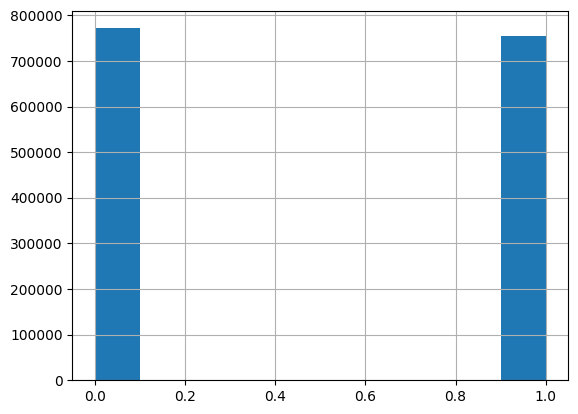

In [67]:
df2['label'].hist()

In [68]:
df2['sentiment'] = df2['label'].apply(lambda x: "negative" if x==0 else "positive")
df2

,label,text,sentiment
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi...",negative
1,0,Est contrarié qu'il ne puisse pas mettre à jou...,negative
2,0,J'ai plongé plusieurs fois pour la balle. A ré...,negative
3,0,Tout mon corps a des démangeaisons et comme si...,negative
4,0,"Non, il ne se comporte pas du tout. je suis en...",negative
...,...,...,...
1526719,1,"Oui, cela fonctionne mieux que de l'attendre à...",positive
1526720,1,Je viens de me réveiller. Ne pas avoir d'école...,positive
1526721,1,Thewdb.com - très cool d'entendre les vieilles...,positive
1526722,1,Êtes-vous prêt pour votre mojo makeover? Deman...,positive


In [69]:
# Séparer les documents en lots de 10 documents maximum
documents = df2["text"].tolist()
batch_size = 10
batches = [documents[i:i+batch_size] for i in range(0, 100, batch_size)]

# Calculer le nombre d'enregistrements de texte utilisés
num_chars = sum([len(phrase) for doc in batches for phrase in doc])
num_text_records = math.ceil(num_chars / 1000)

# Calculer le coût approximatif de l'analyse de sentiment
cost = num_chars / 1000000
print("Nombre total d'enregistrements texte : ", num_text_records)
print("Coût approximatif : ", cost, "$")

Nombre total d'enregistrements texte :  9
Coût approximatif :  0.008433 $


In [70]:
# Analyser chaque lot de documents
successful_responses = []
for batch in batches:
    response = text_analytics_client.analyze_sentiment(batch)
    successful_responses += [doc for doc in response if not doc.is_error]

In [71]:
# Afficher les colonnes
print('{:<10}{:<20}{:<10}'.format('Sentiment', 'Prediction de l\'API', 'Correct?'))


# Calcul du nombre de réponses correctes
num_correct = 0

# Récupération des phrases avec prédiction différente du label
liste_recup = []

# Affichage des résultats ligne par ligne
for i in range(len(successful_responses)):
    # Récupération du sentiment correspondant à la phrase analysée
    sentiment = df2.loc[i, 'sentiment']
    # Récupération de la prédiction de l'API Text Analytics
    prediction = successful_responses[i].sentiment
    # Vérification si la prédiction est correcte
    if sentiment == prediction:
        correct = 1  
    else: 
        correct = 0
        liste_recup += [(df2['text'][i], sentiment, prediction)]

    # Incrémentation du nombre de réponses correctes
    num_correct += correct
    # Affichage de la ligne correspondant au résultat
    print('{:<10}{:<20}{:<10}'.format(sentiment, prediction, correct))

# Calcul et affichage du pourcentage de réponses correctes
accuracy = num_correct / len(successful_responses) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

Sentiment Prediction de l'API Correct?  
negative  negative            1         
negative  negative            1         
negative  positive            0         
negative  negative            1         
negative  negative            1         
negative  negative            1         
negative  positive            0         
negative  mixed               0         
negative  neutral             0         
negative  negative            1         
negative  positive            0         
negative  negative            1         
negative  negative            1         
negative  negative            1         
negative  neutral             0         
negative  mixed               0         
negative  negative            1         
negative  positive            0         
negative  positive            0         
negative  negative            1         
negative  neutral             0         
negative  neutral             0         
negative  neutral             0         
negative  negati

In [72]:
liste_recup

[("J'ai plongé plusieurs fois pour la balle. A réussi à économiser 50% le reste sort de limites",
  'negative',
  'positive'),
 ("besoin d'un câlin", 'negative', 'positive'),
 ('Bonjour pas de vue! Oui ... pleut un peu, juste un peu lol, je vais bien merci, comment ça va?',
  'negative',
  'mixed'),
 ("Non, ils ne l'avaient pas", 'negative', 'neutral'),
 ('Vacances de printemps en ville ordinaire ... il neige',
  'negative',
  'positive'),
 ("J'aurais été le premier, mais je n'avais pas d'arme à feu. Pas vraiment, zac snyder est juste une doucheclown.",
  'negative',
  'neutral'),
 ("J'aimerais que je le regarde avec vous !! Tu me manques et comment était la première?",
  'negative',
  'mixed'),
 ('Sur le point de déposer des taxes', 'negative', 'positive'),
 ('Ahh ive toujours voulu voir le loyer adorer la bande originale !!',
  'negative',
  'positive'),
 ("J'étais dehors la plupart du temps donc je n'ai pas beaucoup fait",
  'negative',
  'neutral'),
 ("Un de mes amis m'a appelé et 

# Test sur des dialogues entre un chatbot et un client

In [129]:
df3 = pd.read_csv("../dialogues_test.csv")
df3

,répliques,label
0,Pourriez-vous me donner plus d'informations su...,neutral
1,Comment puis-je mettre en place un virement au...,neutral
2,Quelle est la procédure pour ouvrir un compte ...,neutral
3,Comment puis-je obtenir un chéquier pour mon c...,neutral
4,Quels sont les avantages de votre assurance ha...,neutral
...,...,...
130,Votre service aprés-vente est extrement déceva...,negative
131,Les délais pour réglé les problèmes sont ridic...,negative
132,Les offres de votre banque sont peux avantageu...,negative
133,Je ne comprend pas pourquoi je paye autant de ...,negative


<Axes: >

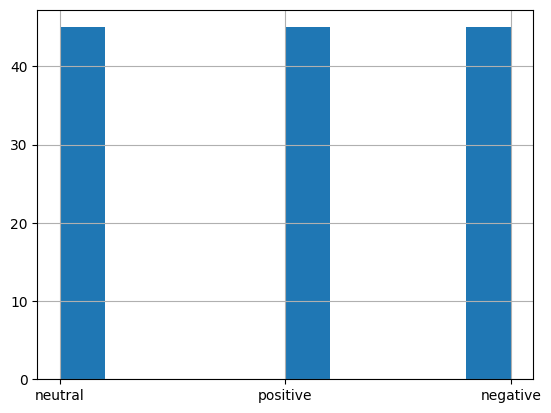

In [135]:
df3['label'].hist()

In [137]:
# Séparer les documents en lots de 10 documents maximum
documents = df3["répliques"].tolist()
batch_size = 5
batches = [documents[i:i+batch_size] for i in range(0, 45, batch_size)]

# Calculer le nombre d'enregistrements de texte utilisés
num_chars = sum([len(phrase) for doc in batches for phrase in doc])
num_text_records = math.ceil(num_chars / 1000)

# Calculer le coût approximatif de l'analyse de sentiment
cost = num_chars / 1000000
print("Nombre total d'enregistrements texte : ", num_text_records)
print("Coût approximatif : ", cost, "$")

Nombre total d'enregistrements texte :  4
Coût approximatif :  0.003166 $


In [132]:
# Analyser chaque lot de documents
successful_responses = []
for batch in batches:
    response = text_analytics_client.analyze_sentiment(batch)
    successful_responses += [doc for doc in response if not doc.is_error]

In [133]:
# Afficher les colonnes
print('{:<10}{:<20}{:<10}'.format('Sentiment', 'Prediction de l\'API', 'Correct?'))


# Calcul du nombre de réponses correctes
num_correct = 0

# Récupération des phrases avec prédiction différente du label
liste_recup = []

# Affichage des résultats ligne par ligne
for i in range(len(successful_responses)):
    # Récupération du sentiment correspondant à la phrase analysée
    sentiment = df3.loc[i, 'label']
    # Récupération de la prédiction de l'API Text Analytics
    prediction = successful_responses[i].sentiment
    # Vérification si la prédiction est correcte
    if sentiment == prediction:
        correct = 1  
    else: 
        correct = 0
        liste_recup += [(df3['répliques'][i], sentiment, prediction)]

    # Incrémentation du nombre de réponses correctes
    num_correct += correct
    # Affichage de la ligne correspondant au résultat
    print('{:<10}{:<20}{:<10}'.format(sentiment, prediction, correct))

# Calcul et affichage du pourcentage de réponses correctes
accuracy = num_correct / len(successful_responses) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

Sentiment Prediction de l'API Correct?  
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   negative            0         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
neutral   neutral             1         
positive  positive            1         
positive  positive            1         
positive  positive            1         
positive  positive            1         
positive  positive            1         
positive  positive            1         
positive  positive            1         
positive  neutral             0         
positive  positi

In [134]:
liste_recup

[("Comment fonctionne l'option de paiement sans contact de ma carte bancaire ?",
  'neutral',
  'negative'),
 ("Les taux d'intérêt de votre banque sont très compétitifs, je suis ravi.",
  'positive',
  'neutral'),
 ("J'ai dû attendre une éternité pour avoir une réponse à ma question.",
  'negative',
  'neutral'),
 ('Cette expérience a été extrêmement décevante et je vais envisager de changer de banque.',
  'negative',
  'positive')]